In [45]:
using Pkg
using Base.Sort
using MAT
using StatsBase
using Printf
using LinearAlgebra
using PyCall
using GLM
using Interpolations
scilin = pyimport("scipy.linalg");

In [46]:
datadir="../data_RGCs/"
function readmat(filename::String)
    file=matopen(join([datadir,filename,".mat"]))
    Stim=read(file,filename)
    close(file)
    return Stim
end

Stim=readmat("Stim")
stimtimes=readmat("stimtimes")
SpTimes=readmat("SpTimes");

In [47]:
cellnum=3 #(1-2 are OFF cells; 3-4 are ON cells).
tsp=SpTimes[cellnum];

In [48]:
dtStim=stimtimes[2]-stimtimes[1] # time bin size for stimulus(s)
RefreshRate=1/dtStim # Refresh rate of the monitor
nT=size(Stim)[1] # stim frame times in seconds (if desired)
nsp=size(tsp)[1]; # load spike times (in units of stim frames)

In [49]:
@printf("--------------------------\n")
@printf("Loaded RGC data: cell %d\n",cellnum)
@printf("Number of stim frames: %d  (%.1f minutes)\n",nT, nT*dtStim/60)
@printf("Time bin size: %.1f ms\n",dtStim*1000)
@printf("Number of spikes: %d (mean rate=%.1f Hz)\n",nsp, nsp/nT*RefreshRate)

--------------------------
Loaded RGC data: cell 3
Number of stim frames: 144051  (20.0 minutes)
Time bin size: 8.3 ms
Number of spikes: 49954 (mean rate=41.6 Hz)


In [50]:
using Plots
pyplot()
default(size = (600, 400),tickfontsize=10,legendfontsize=10)

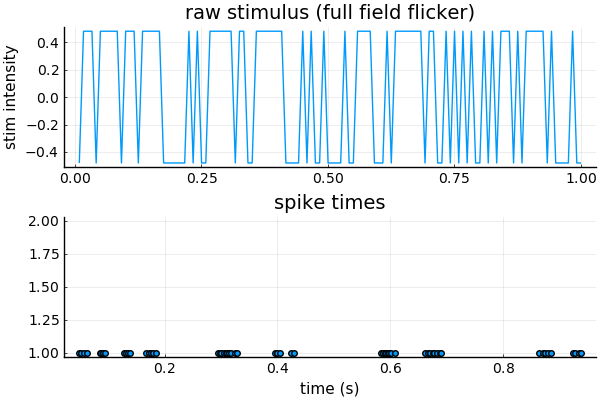

In [51]:
iiplot=1:120
ttplot=iiplot*dtStim
tspplot=tsp[(tsp.>=ttplot[1]).&(tsp.<ttplot[end])]
p1=plot(ttplot,Stim[iiplot],ylabel="stim intensity",title="raw stimulus (full field flicker)")
p2=plot(tspplot,fill(1,size(tspplot)),seriestype = :scatter,xlabel="time (s)",title="spike times")
plot(p1,p2,layout=(2,1),legend=false)

In [52]:
tbins=(.5:1:nT+.5)*dtStim;
sps = fit(Histogram,tsp[:],tbins).weights;

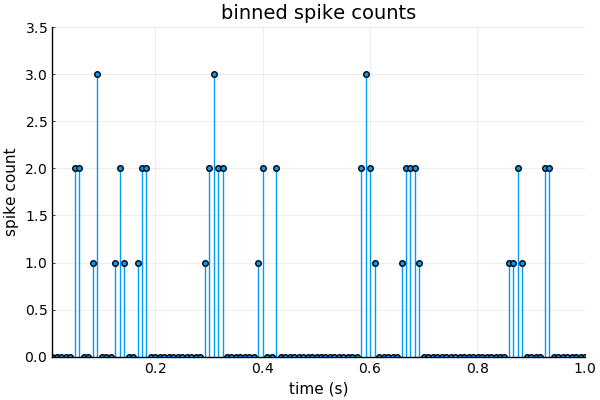

In [53]:
plot(ttplot,sps[iiplot],line=:stem,marker=:circle,
    title="binned spike counts",xlabel="time (s)",ylabel="spike count",
    xlims=(ttplot[1],ttplot[end]),
    ylims=(0,3.5),
    legend=false)

In [54]:
ntfilt=25;

In [55]:
paddedStim=vcat(fill(0.,ntfilt-1),Stim)
Xdsgn=fill(0.,(nT,ntfilt))
for j in 1:nT
    Xdsgn[j,:]=paddedStim[j:j+ntfilt-1]'
end

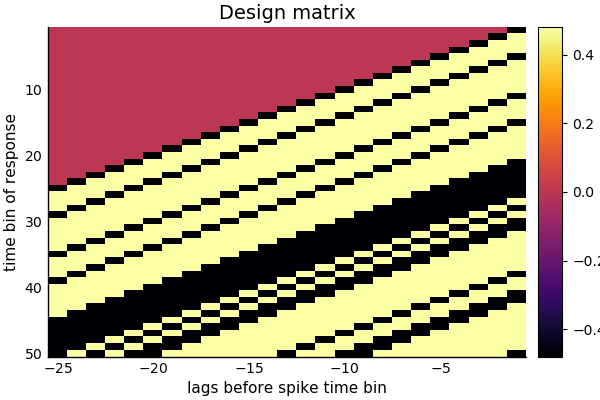

In [56]:
heatmap(-25:1:-1,1:50,Xdsgn[1:50,:],yflip=true,
    title="Design matrix",
    xlabel="lags before spike time bin",
    ylabel="time bin of response")

In [57]:
paddedStim=vcat(fill(0.,ntfilt-1),Stim)
Xdsgn=scilin.hankel(paddedStim[1:end-ntfilt+1],Stim[end-ntfilt:end]);

In [58]:
sta=Xdsgn'sps/nsp;

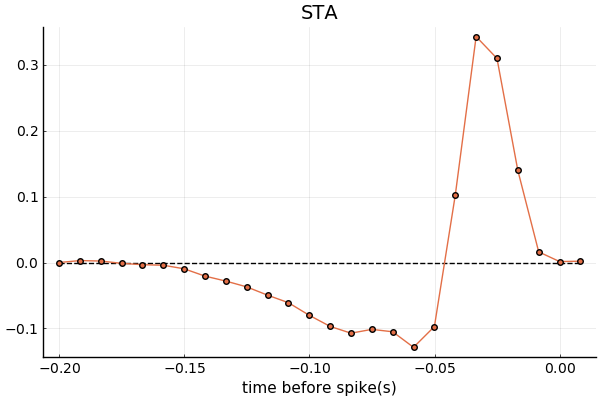

In [59]:
ttk=(-ntfilt+1:1)*dtStim
plot(ttk,ttk*0,line=:dash,color=:black,
    xlabel="time before spike(s)",title="STA",legend=false)
plot!(ttk,sta,marker=:circle)

In [60]:
wsta=Xdsgn'Xdsgn\sta*nsp;

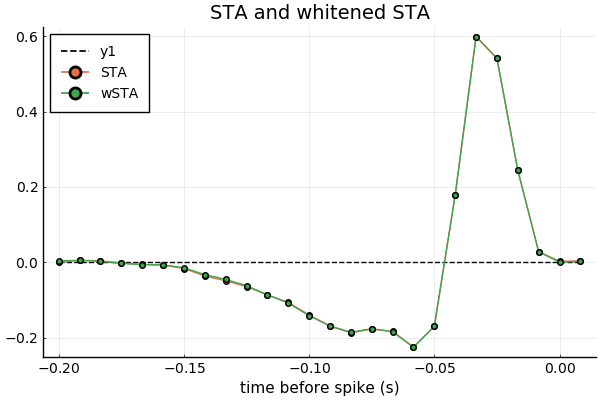

In [61]:
plot(ttk,ttk*0,line=:dash,color=:black,title="STA and whitened STA",xlabel="time before spike (s)")
plot!(ttk,sta/norm(sta),marker=:circle,label="STA")
plot!(ttk,wsta/norm(wsta),marker=:circle,label="wSTA")

In [62]:
sppred_lgGLM=Xdsgn*wsta;

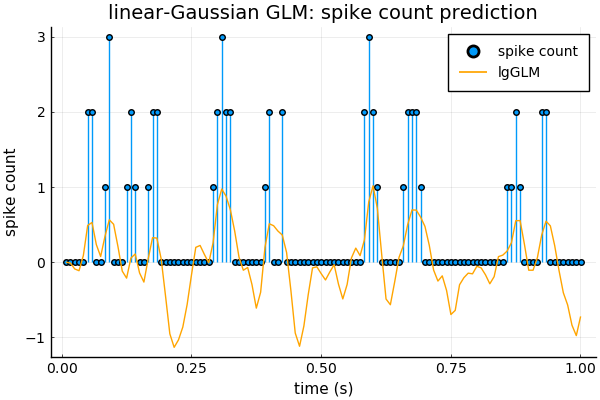

In [63]:
plot(ttplot,sps[iiplot],line=:stem,marker=:circle,label="spike count",
    title="linear-Gaussian GLM: spike count prediction",ylabel="spike count",xlabel="time (s)")
plot!(ttplot,sppred_lgGLM[iiplot],color="orange",label="lgGLM")

In [64]:
Xdsgn2=hcat(fill(1,nT),Xdsgn);

In [65]:
MLwts=Xdsgn2'Xdsgn2\(Xdsgn2'sps);
const_=MLwts[1]
wsta2=MLwts[2:end];

In [66]:
sppred_lgGLM2=const_.+Xdsgn*wsta2;

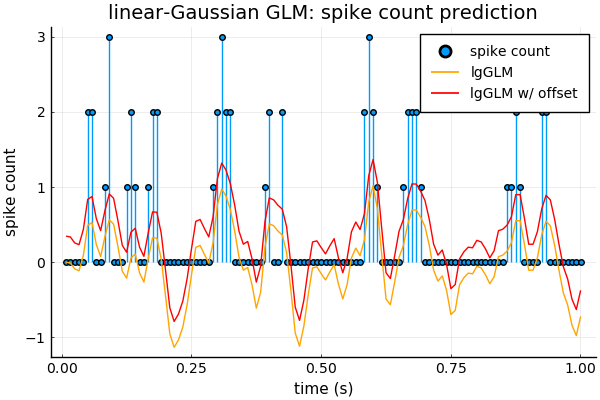

In [67]:
plot(ttplot,sps[iiplot],line=:stem,marker=:circle,label="spike count",
    title="linear-Gaussian GLM: spike count prediction",
    ylabel="spike count",xlabel="time (s)")
plot!(ttplot,sppred_lgGLM[iiplot],color="orange",label="lgGLM")
plot!(ttplot,sppred_lgGLM2[iiplot],color="red",label="lgGLM w/ offset")

In [152]:
mse1=mean((sps-sppred_lgGLM).^2)
mse2=mean((sps-sppred_lgGLM2).^2)
rss=mean((sps.-mean(sps)).^2);

In [69]:
@printf("Training perf (R^2): lin-gauss GLM, no offset: %.2f\n",(1-mse1/rss))
@printf("Training perf (R^2): lin-gauss GLM, w/ offset: %.2f\n",(1-mse2/rss))

Training perf (R^2): lin-gauss GLM, no offset: 0.12
Training perf (R^2): lin-gauss GLM, w/ offset: 0.39


In [70]:
model = glm(Xdsgn2,sps, Poisson(), LogLink())
pGLMwts=coef(model)
pGLMconst=pGLMwts[1]
pGLMfilt=pGLMwts[2:end];

In [71]:
ratepred_pGLM=exp.(pGLMconst.+Xdsgn*pGLMfilt);

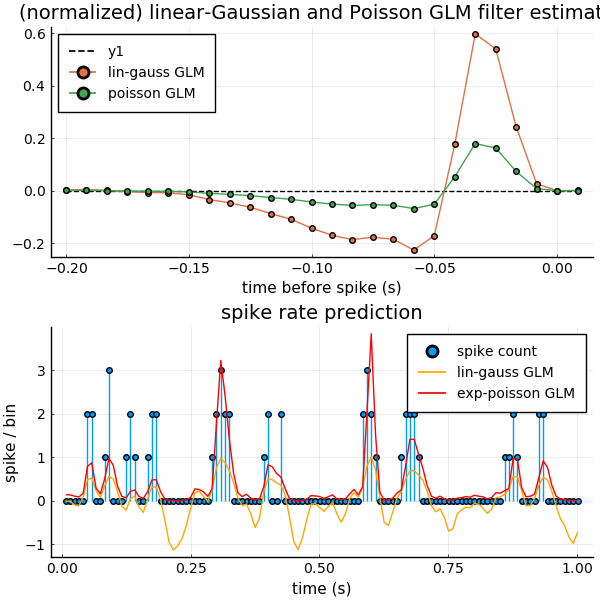

In [72]:
p1=plot(ttk,ttk*0,line=:dash,color=:black,
    title="(normalized) linear-Gaussian and Poisson GLM filter estimates",
    xlabel="time before spike (s)")
plot!(ttk,wsta2/norm(wsta2),marker=:circle,label="lin-gauss GLM")
plot!(ttk,wsta2/norm(pGLMfilt),marker=:circle,label="poisson GLM")

p2=plot(ttplot,sps[iiplot],line=:stem,marker=:circle,label="spike count",
    title="spike rate prediction",
    ylabel="spike / bin",xlabel="time (s)")
plot!(ttplot,sppred_lgGLM[iiplot],color="orange",label="lin-gauss GLM")
plot!(ttplot,ratepred_pGLM[iiplot],color="red",label="exp-poisson GLM")

plot(p1,p2,layout=(2,1),size=(600,600))

In [73]:
nfbins=25;

In [74]:
rawfilteroutput=pGLMconst.+Xdsgn*pGLMfilt;

In [75]:
binedges=LinRange(minimum(rawfilteroutput),maximum(rawfilteroutput),nfbins+1)
histh = fit(Histogram,rawfilteroutput,binedges);
binedges=histh.edges[1]
cts=histh.weights
binID=searchsortedfirst.(Ref(binedges),rawfilteroutput)
fx=binedges[1:end-1].+(binedges[2]-binedges[1])/2

25-element LinRange{Float64}:
 -5.87494,-5.54602,-5.21711,-4.88819,-4.55928,…,1.03228,1.3612,1.69011,2.01903

In [76]:
fy=fill(0.,nfbins)
for jj in 1:nfbins
    fy[jj]=mean(sps[binID.==jj])
end
fy/=dtStim;

In [77]:
itp=interpolate(fy,BSpline(Constant()))
etpf=extrapolate(itp,Flat())
fnlin=scale(etpf,fx);

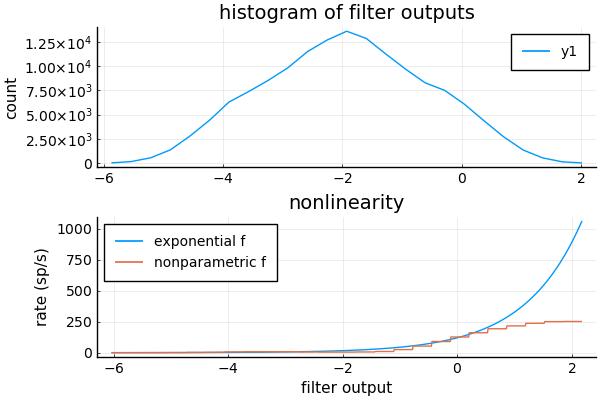

In [78]:
p1=plot(fx,cts,
    ylabel="count",title="histogram of filter outputs")
xx=binedges[1]:0.01:binedges[end]
p2=plot(xx,exp.(xx)/dtStim,
    label="exponential f",
    title="nonlinearity",
    xlabel="filter output",ylabel="rate (sp/s)")
plot!(xx,fnlin.(xx),label="nonparametric f")
plot(p1,p2,layout=(2,1))

In [79]:
ratepred_pGLM=exp.(pGLMconst.+Xdsgn*pGLMfilt)
LL_expGLM=sps'*log.(ratepred_pGLM)-sum(ratepred_pGLM)

-65002.32488088761

In [80]:
ratepred_pGLMnp=dtStim*fnlin.(pGLMconst.+Xdsgn*pGLMfilt)
LL_npGLM=sps[sps.>0]'*log.(ratepred_pGLM[sps.>0])-sum(ratepred_pGLMnp)

-52218.49661751992

In [81]:
ratepred_const=nsp/nT
LL0=nsp*log(ratepred_const)-nT*ratepred_const

-102858.52409681036

In [82]:
SSinfo_expGLM=(LL_expGLM-LL0)/nsp/log(2)
SSinfo_npGLM=(LL_expGLM-LL0)/nsp/log(2)

1.0933048579836735

In [83]:
@printf("\n empirical single-spike information:\n ---------------------- \n")
@printf("exp-GLM: %.2f bits/sp\n",SSinfo_expGLM)
@printf(" np-GLM: %.2f bits/sp\n",SSinfo_npGLM)


 empirical single-spike information:
 ---------------------- 
exp-GLM: 1.09 bits/sp
 np-GLM: 1.09 bits/sp


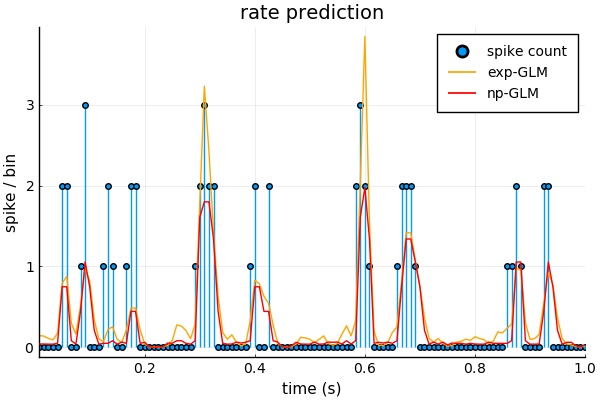

In [84]:
plot(ttplot,sps[iiplot],line=:stem,marker=:circle,label="spike count",
    title="rate prediction",
    ylabel="spike / bin",
    xlabel="time (s)",
    xlims=(ttplot[1],ttplot[end])
)
plot!(ttplot,ratepred_pGLM[iiplot],color="orange",label="exp-GLM")
plot!(ttplot,ratepred_pGLMnp[iiplot],color="red",label="np-GLM")

In [85]:
AIC_expGLM = -2*LL_expGLM + 2*(1+ntfilt)
AIC_npGLM = -2*LL_npGLM + 2*(1+ntfilt+nfbins)

@printf("\n AIC comparison:\n ---------------------- \n")
@printf("exp-GLM: %.1f\n",AIC_expGLM)
@printf(" np-GLM: %.1f\n",AIC_npGLM)
@printf("\nAIC diff (exp-np)= %.2f\n",AIC_expGLM-AIC_npGLM)
if AIC_expGLM < AIC_npGLM
    @printf("AIC supports exponential-nonlinearity!\n")
else
    @printf("AIC supports nonparametric nonlinearity!\n")
    # (despite its greater number of parameters)
end


 AIC comparison:
 ---------------------- 
exp-GLM: 130056.6
 np-GLM: 104539.0

AIC diff (exp-np)= 25517.66
AIC supports nonparametric nonlinearity!


In [125]:
iiplot = 1:60 # time bins of stimulus to use
ttplot = iiplot*dtStim # time indices for these stimuli
StimRpt = Stim[iiplot] # repeat stimulus 
nrpts = 50 # number of repeats
frate = exp.(pGLMconst.+Xdsgn[iiplot,:]*pGLMfilt); # firing rate in each bin

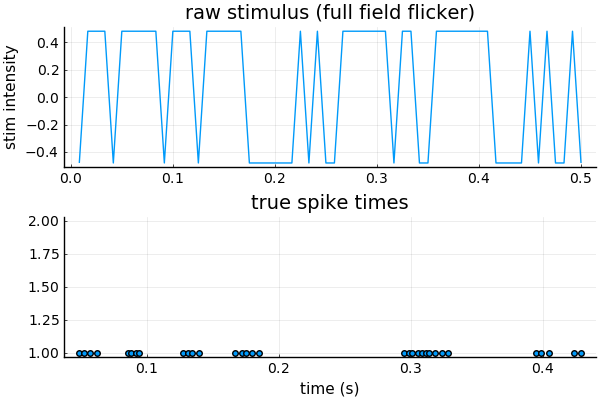

In [126]:
tspplot=tsp[(tsp.>=ttplot[1]).&(tsp.<ttplot[end])]
p1=plot(ttplot,Stim[iiplot],ylabel="stim intensity",title="raw stimulus (full field flicker)")
p2=plot(tspplot,fill(1,size(tspplot)),seriestype = :scatter,xlabel="time (s)",title="true spike times")
plot(p1,p2,layout=(2,1),legend=false)

In [127]:
using Random,Distributions

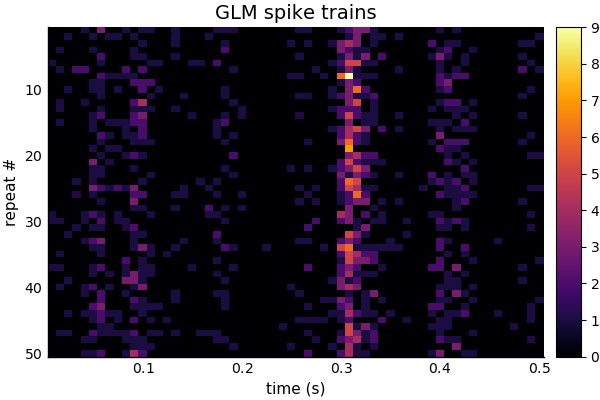

In [151]:
spscounts=reduce(hcat,[rand(Poisson(f),nrpts) for f in frate])
heatmap(ttplot,1:nrpts,spscounts,yflip=true,
    title="GLM spike trains",
    xlabel="time (s)",
    ylabel="repeat #")

In [129]:
upsampfactor = 100 # divide each time bin by this factor
dt_fine = dtStim/upsampfactor # use bins 100 time bins finer
tt_fine = dt_fine/2:dt_fine:ttplot[end];

In [134]:
itp=interpolate(frate,BSpline(Constant()))
etpf=extrapolate(itp,Flat())
frate_fine=scale(etpf,ttplot).(tt_fine)./upsampfactor;

In [147]:
spscounts_fine=reduce(hcat,[rand(Poisson(f),nrpts) for f in frate_fine]);

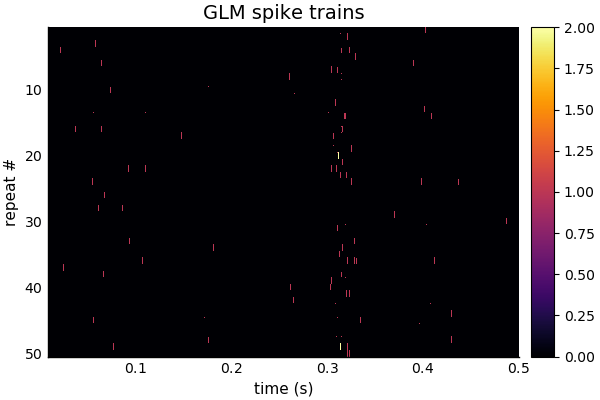

In [150]:
heatmap(LinRange(ttplot[1],ttplot[end],size(tt_fine)[1]),1:nrpts,spscounts_fine,yflip=true,
    title="GLM spike trains",
    xlabel="time (s)",
    ylabel="repeat #")